# BigTable MTLM - summative Q-Matrix mining
(Based on Cen 2009)
This model is used to explain the power law in learning.  In this notebook we try to build a neuralised version of the AFM and train it using simulated data.  The aim of using the AFM is to disentangle the latent traits that make up the overall score going into the sigmoid probability estimator.

The model is compensatory, which is a weakness.

In [2]:
from collections import defaultdict, Counter
from copy import copy
from math import exp, sqrt, log
from random import random, shuffle, choice, randint, uniform
import numpy
import math

from keras import Input, Model
from keras.callbacks import EarlyStopping
from keras.constraints import non_neg, max_norm
from numpy import array, mean, ones
from pandas import concat
from pandas import DataFrame
from keras.models import Sequential
from keras.layers import LSTM, multiply, subtract, add, Activation, Lambda, Flatten
from keras.layers import Dense, concatenate, MaxPooling1D, LocallyConnected1D, Reshape, Dropout
from keras.optimizers import Adam, SGD
from keras import backend as K
from keras import constraints

import tensorflow as tf

from utils import generate_student_name
import random

from matplotlib import pyplot as plt

# n_traits = 10
# active_traits = 10


Using TensorFlow backend.


In [3]:
generate_student_name()

'THUT CEDI '

In [4]:
from keras import backend as K
from keras.constraints import Constraint
from keras.engine.topology import Layer
from keras import initializers

class WeightClip(Constraint):
    '''Clips the weights incident to each hidden unit to be inside a range
    '''
    def __init__(self, min_w=0, max_w=4):
        self.min_w = min_w
        self.max_w = max_w

    def __call__(self, p):
        return K.clip(p, self.min_w, self.max_w)

    def get_config(self):
        return {'name': self.__class__.__name__,
                'min_w': self.min_w,
                'max_w': self.max_w }

In [5]:
active_traits = 100
for z in [-20, -10, -4,-3,-2,-1,0,1,2,3,4]:
    print(z, 1/(1+exp(-z)) )

# q_p_avg = 0.45
q_p_easiest = 0.99
q_p_hardest = 0.01
mid = (q_p_easiest + q_p_hardest)/2.0

# pr_k_avg = q_p_avg**(1/n_traits)
# print("pr k avg:", pr_k_avg)

pr_k_easiest = q_p_easiest**(1/active_traits)
pr_k_hardest = q_p_hardest**(1/active_traits)

inv_sigmoid = lambda pr : ( -log((1/pr) -1) )
easy_comp_del = inv_sigmoid(pr_k_easiest)
hard_comp_del = inv_sigmoid(pr_k_hardest)

offset = (easy_comp_del - hard_comp_del)/2
baseline = 1
beta_min = baseline+0
# beta_max = baseline+round(offset,1)
# theta_min = baseline+round(easy_comp_del - offset,1)
# theta_max = baseline+round(easy_comp_del,1)
beta_max = baseline+(offset)
theta_min = baseline+(easy_comp_del - offset)
theta_max = baseline+(easy_comp_del)

# beta_min = 0
# beta_max = 10
# theta_min = 5
# theta_max = 15


print("b", beta_min, beta_max)
print("th", theta_min, theta_max)

worst_comp_pr = 1/(1+exp(-(theta_min - beta_max)))
best_comp_pr = 1/(1+exp(-(theta_max - beta_min)))

null_task_pr = 1/(1+exp(-baseline))
print("null-task passrate", null_task_pr)
print("all-null passrate", null_task_pr**active_traits)

print("worst cmp chance=", worst_comp_pr)
print("best cmp chance=", best_comp_pr)

print("worst Pr=", worst_comp_pr**active_traits)
print("best Pr=", best_comp_pr**active_traits)

min_min = 1/(1+exp(-(theta_min - beta_min)))
max_max = 1/(1+exp(-(theta_max - beta_max)))
print("limits", min_min, max_max)


nom = array([
    [1,2,3],
    [4,5,6],
    [7,8,9],
])

sel = nom[[0,2]]
print(sel)
print(sel.shape)


-20 2.0611536181902037e-09
-10 4.5397868702434395e-05
-4 0.01798620996209156
-3 0.04742587317756678
-2 0.11920292202211755
-1 0.2689414213699951
0 0.5
1 0.7310585786300049
2 0.8807970779778823
3 0.9525741268224334
4 0.9820137900379085
b 1 4.075196407410573
th 7.130072753253939 10.205269160664512
null-task passrate 0.7310585786300049
all-null passrate 2.4843785557240134e-14
worst cmp chance= 0.9549925860214361
best cmp chance= 0.9998995016917583
worst Pr= 0.010000000000000165
best Pr= 0.9900000000000009
limits 0.9978283039153395 0.9978283039153395
[[1 2 3]
 [7 8 9]]
(2, 3)


In [6]:
class BigTable(Layer):

    def __init__(self, _dim, min_w=0, max_w=10, **kwargs):
        self.dim = _dim
        self.limits = (min_w, max_w)
        kc =kernel_constraint=WeightClip(min_w, max_w)
        self.kernel_constraint= constraints.get(kc)
        super(BigTable, self).__init__(**kwargs)
        
    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        min_w, max_w = self.limits
        av_w = (min_w + max_w)/2.0
        initialiser = initializers.RandomUniform(min_w, max_w)
        self.kernel = self.add_weight(name='kernel', 
                                      shape=(self.dim),
                                      initializer=initialiser,
                                      trainable=True,
                                      constraint=self.kernel_constraint)
        print("kk", self.kernel.shape)
        super(BigTable, self).build(input_shape)  # Be sure to call this at the end

    def call(self, selector):
        print("selector shape", selector.shape)
        selector = K.flatten(selector)
        print("flat selector shape", selector.shape)
        print("call kk", self.kernel.shape)
#         selector = tf.Print(selector, [selector], message="selector is:", first_n=-1, summarize=1024)
        rows = K.gather(self.kernel, selector)
#         rows = tf.Print(rows, [rows], message="row is:", first_n=-1, summarize=1024)
        print("'rows' shape,",rows.shape)
        return rows

    def compute_output_shape(self, input_shape):
        return ((None, self.dim[1]))


In [23]:
class Question():
    active_traits = 5
    def __init__(self, qix, min_diff, max_diff, nt=None, nnw=None, optimiser=None):
        self.id = qix
        print("nt", nt)
        print("nnw", nnw)

#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        n_c =  numpy.random.choice(range(1,active_traits))
#         n_c = nt
        choices = numpy.random.choice(range(nnw), size=n_c, replace=False)
#         mass = random.uniform(0,(max_diff-min_diff)*len(choices))

        not_present= 0#min_diff
        self.betas = [ not_present for _ in range(nnw) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.betas[c] = random.uniform(min_diff, max_diff)
            self.betas[c]= uniform(min_diff, max_diff) #(1,11)
    
class Student():
    def __init__(self, ix, min_a, max_a, nt=None, nnw=None, optimiser=None):
        self.id = ix
        self.name = generate_student_name()
        n_c = nt
#         n_c = numpy.random.choice(range(int(nt/2),nt+1))
#         n_c = numpy.random.choice(range(1,nt+1))
        choices = numpy.random.choice(range(nt), size=n_c, replace=False)
#         mass = random.uniform(0,(max_a-min_a)*len(choices))

        not_present= 0 #min_a
        self.thetas = [ not_present for _ in range(nt) ]        

        for c in choices:
#             self.betas[c] = min_diff
#             self.thetas[c] = random.uniform(min_a, max_a)  
            self.thetas[c] = uniform(min_a, max_a) #(7,22)


In [8]:
def attempt_q(student: Student, q: Question):
    p = calculate_pass_probability(student.thetas, q.betas)
    this_att = uniform(0,1)
    if (this_att <= p):
        passed=1
#         print("passed")
#         student.mastery[q.id] = 1
    else:
        passed=0

    return p,passed

In [9]:
def calculate_pass_probability(thetas, betas):
    p_pass = 1.0
    for th,b in zip(thetas,betas):
        if b==0:
            p_pass_step=1.0
        else:
            if th==0:
#                 print("blocking component, ret 0")
                return 0
            else:
                z = (th-b)
                p_pass_step = 1.0 / (1.0 + exp(-z))
#                 print(th,"vs",b,": ", p_pass_step)
        p_pass *= p_pass_step # simple conjunctive model of success!
    try:
        pass
#         print("p_pass={}".format(p_pass))
    except OverflowError:
        p_pass = 0.0
    #print("real p_pass = {}".format(p_pass))
    return p_pass
    

In [10]:
def create_qs(n_qs, beta_min, beta_max, nt, nnw):
#     random.seed(666)
#     numpy.random.seed(666)
    master_qs = [Question(qix, beta_min,beta_max, nt=nt, nnw=nnw) for qix in range(n_qs)]
    mags = []
    no_comps = []
    for q in master_qs:
        comps = [c for c in q.betas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("Q:{}, difficulty={:.2f} across {} components".format(q.id, mag, len(comps)))
        mags.append(mag)
        no_comps.append(len(comps))
    
    plt.hist(mags)
    plt.show()
    plt.hist(no_comps)
    plt.show()
    
    for q in master_qs:
        print("qid",q.id,q.betas)
    
    qn_table = BigTable((n_qs, nnw),min_w=beta_min, max_w=beta_max)
    
    return master_qs, qn_table

In [11]:
def create_students(n_students, theta_min, theta_max, nt, nnw):
#     random.seed(666)
#     numpy.random.seed(666)
    psi_list = [ Student(psix, theta_min,theta_max, nt=nt, nnw=nnw) for psix in range(n_students)]
    mags = []
    for psi in psi_list[0:30]:
#         print(psi.name, psi.thetas)
        comps = [c for c in psi.thetas if c>0]
        mag = sqrt(sum([ pow(b, 2) for b in comps ]))
        print("{}, skill={:.2f} across {} comps".format(psi.name, mag, len(comps)))
        mags.append(mag)
    
    psi_table = BigTable((n_students, nnw), min_w=theta_min, max_w=theta_max)
    print("psi_table wgts", psi_table.get_weights())
 ################ PLOTs follow

    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    ax[0].hist(mags)

    if nt >1:
        itemz = array([ s.thetas for s in psi_list ])
    #     fig.set_size_inches(10, 10)
        ax[1].scatter(itemz[:,0], itemz[:,1], alpha=0.2)
        for i, txt in enumerate(itemz):
            ax[1].annotate(i, (itemz[i,0], itemz[i,1]))
        plt.show()
    
    return psi_list, psi_table
    

In [12]:
def generate_qs_model(qn_table, psi_table, qn_qmx, psi_qmx, optimiser):
    psi_sel = Input(shape=(1,), name="psi_select", dtype="int32")
    qn_sel = Input(shape=(1,), name="q_select", dtype="int32")
    print(qn_table, psi_table, psi_sel, qn_sel)
    print("psi_sel shape", psi_sel.shape)

    psi_table.trainable=True
    qn_table.trainable=True
#     qn_qmx.trainable = True
#     psi_qmx.trainable = True
    
    qn_row = qn_table(qn_sel)
    psi_row = psi_table(psi_sel)

#     qn_qmx_row = qn_qmx(qn_sel)
#     psi_qmx_row = psi_qmx(psi_sel)

#     not_q = Lambda(lambda z: 1.0 / (1.0 + K.exp(10.0*z-5)), name="NOT_GATE")(qn_qmx_row)
#     scale = Lambda(lambda x1: 10.0*x1)
#     scale_sub = Lambda(lambda x2: 10.0*x2 - 5.0)

    
    ####
    # q0,s0 -> 1
    # q0,s1 -> 1
    # q1,s0 -> 0
    # q1,s1 -> cPr
    
#     p = scale_sub(psi_row)
#     not_q = scale(not_q)
#     qmx_selector = add([p, not_q])

    q_masque = Lambda(lambda q: K.clip(q,0,1))(qn_row)
    s_masque = Lambda(lambda s: K.clip(s,0,1))(psi_row)
#     q_masque = qn_row
#     s_masque = psi_row

#     q1_s1 = Lambda(lambda qs: qs[0] * qs[1])([q_masque, s_masque])
#     q0 = Lambda(lambda q: 1-q)(q_masque)

    dif = subtract([psi_row, qn_row])
    print("dif",dif.shape)
    Prs = Lambda(lambda z: 1.0 / (1.0 + K.exp(-z)), name="sPr_sigmoid")(dif)

#     Prs = multiply([Prs, q1_s1])
#     Prs = add([Prs, q0])
    
#     topped_up = Lambda(lambda ps_q:  K.clip(ps_q[0]+(1.0-ps_q[1]), 0,1))([Prs_holed, q_masque])

#     Prs = Lambda(lambda u: K.clip(u,0,1)) (add([Prs, qmx_selector]))
#     Prs = multiply([Prs, qmx_selector])

    Pr = Lambda(lambda ps: K.prod(ps, axis=1, keepdims=True), name="sPr_prod")(Prs)
    print("Pr",Pr.shape)
    model = Model(inputs=[qn_sel, psi_sel], outputs=Pr)
    model.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["mse","accuracy"])
    return model

# Training
This is where sh!t gets real.  We take our tr_len (1000?) students, and iterate over them 100 times to create 100,000 *complete examples* of a student attacking the curriculum.  The questions themselves are attacked in random order: the student has no intelligent guidance throught the material. (Obvious we may wish to provide that guidance at some point in the future.)

Remember, there are only 12 exercises in the curriculum, so if the student is taking 60 or 70 goes to answer them all, that's pretty poor.  But some of these kids are dumb as lumber, so cut them some slack!  They will all get there in the end since by the CMU AFM practice will, eventually, make perfect!

In [13]:
import gc
def generate_attempts(master_qs, psi_list):
    attempts =[]
    attempts_by_q = {}
    attempts_by_psi = {}
    attempt_n_map = Counter()

    user_budget = math.inf
    user_patience = 10 #math.inf
    pass_to_remove = True
    
    n_pass = 0
    for run in range(1):
        print("----{}\n".format(run))
        for psi in psi_list:
            spend=0
            qs = [ix for ix in range(len(master_qs))]
            while qs:
                qix = random.choice(qs)
                q = master_qs[qix]
                passed=0

                if psi.name not in attempts_by_psi:
                    attempts_by_psi[psi.name]=[]

                if q not in attempts_by_q:
                    attempts_by_q[q]=[]

                att = 0
#                 while (not passed) and att<user_patience:
                pp,passed = attempt_q(psi, q)
                if passed:
                    n_pass+=1
                tup = (psi.id, q.id, passed, passed)
                attempt_n_map[(q.id,psi.id)] += 1
                attempts.append(tup)
#                 print("p_pass was",pp,"=",passed) #, "run p:", 1-(1-pp)**max_atts)
                attempts_by_psi[psi.name].append(tup)
                attempts_by_q[q].append(tup)
                att += 1
#                 if (not pass_to_remove) or (pass_to_remove and passed):
                qs.remove(qix)
#                 print("len qs is", len(qs))
    gc.collect()
    print(">>Passed {}/{}".format(n_pass, len(attempts)))
    return attempts, attempts_by_q, attempts_by_psi, attempt_n_map

In [14]:
def init_weights(master_qs, psi_list, attempts_by_psi, attempts_by_q, q_table, s_table, min_b, max_b, min_th, max_th):
    psi_wgts = s_table.get_weights()[0]
    for s in psi_list:
#         attz = [tup[2] for tup in attempts_by_psi[s.name]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log(p / (1-p))
        psi_wgts[s.id,:] = numpy.random.uniform(min_th,max_th, size=psi_wgts.shape[1])
        print(psi_wgts[s.id,:])
    s_table.set_weights([ psi_wgts ])

    qn_wgts = q_table.get_weights()[0]
    for q in master_qs:
#         attz = [tup[2] for tup in attempts_by_q[q]]
#         prop = mean(attz)
#         p = prop**(1/n_traits)
#         cw_prop = log((1-p) / p)
        qn_wgts[q.id,:]= numpy.random.uniform(min_b,max_b, size=qn_wgts.shape[1])
        print(qn_wgts[q.id,:])
    q_table.set_weights([ qn_wgts ])
    

In [15]:
import os
import IPython

def calibrate(master_qs, psi_list, qs_model, q_model, s_model, attempts, val, attempts_by_psi, attempts_by_q, s_table, q_table, s_qmx_table, q_qmx_table, n_iter=20, record_param_fit=False):
    es = EarlyStopping(monitor="val_loss", mode="auto", patience=0)
    random.seed(666)
    min_mse = 1000
    min_avg_fit_rmse = math.inf
    min_loss= math.inf
    q_outer_mses = []
    q_outer_accs = []
    s_outer_mses = []
    s_outer_accs = []
    th_mses = []
    b_mses = []
    th_accs= []
    b_accs =[]
    h= []
    avg_fit_rmses = []
    th_fit_rmses = []
    b_fit_rmses = []
    init_patience = 10
    patience = init_patience

    print(attempts[0:100])

    qices = array([int(tup[1]) for tup in attempts]).flatten() #reshape(-1,1)
    psices = array([int(tup[0]) for tup in attempts]).flatten() #reshape(-1,1)
    pfs = array([tup[2] for tup in attempts]).flatten() #reshape(-1,1)
    len_all = qices.shape[0]
    
    vqices = array([int(tup[1]) for tup in val]).flatten() #reshape(-1,1)
    vpsices = array([int(tup[0]) for tup in val]).flatten() #reshape(-1,1)
    vpfs = array([tup[2] for tup in val]).flatten() #reshape(-1,1)

    qz = qices
    sz = psices
    pfz = pfs

    
    print(qz)
    print(sz)
    print(pfz)
#     input("Xsan")
    
    loss = False
    mse = False
    acc = False
    early_stop = True
    min_stop = 0
#     n_iter = 1
    for i in range(n_iter):
        base_ix = 0
        done = False
#         for j in range(chunkz+1):
        j = 0
        sub_h = []
        
        qs_model.train_on_batch(x=[qz, sz], y=pfz)#, epochs=10, shuffle=True, batch_size=1, callbacks=[es])

        if i % 10 == 0:
            loss, mse, acc = qs_model.evaluate(x=[vqices, vpsices], y=vpfs, verbose=0) #, epochs=1, shuffle=True, batch_size=1, verbose=0) #, callbacks=[es])
            sub_h.append((loss,mse,acc))


            print("i =",i)
     
            print(loss,mse,acc)
            sub_h = numpy.array(sub_h)
            sub_tup = (sub_h[-1,0],sub_h[-1,1],sub_h[-1,2])
            h.append(sub_tup)
#             av_rmse = (th_rmse/len(psi_list) +b_rmse/len(master_qs))
#             av_rmse = acc #(th_rmse+b_rmse)/2.0
#             av_rmse = b_rmse
            av_rmse = loss
            print("av RMSE=",av_rmse)
            if av_rmse <= min_avg_fit_rmse:
                patience = init_patience
                print("patience reset to", init_patience)
                min_avg_fit_rmse = av_rmse
                min_loss = loss
#                 qs_model.save_weights("qs_best_weights_summative.hdf5")
            else:
                if early_stop and i>min_stop:
#                 if loss < min_loss:
#                     print(loss,"<",min_loss)
                    if patience >0:
                        patience -= 1
                        print("patience now", patience)
                    else:
                        print("Earlying stoppin' @",i)
                        break
                    
    #     del h
    #     loss, mse, acc = qs_model.evaluate(x=[qices, psices], y=pfs)

    #     print(loss, mse, acc)
    return h


In [16]:
def calc_arr_arr_err(real_wgts, pred_wgts, max_iter=10):
    from scipy.spatial.distance import cosine
# pred_wgts = numpy.round(pred_wgts,1)

    out_cols = [None] * len(real_wgts.T)
    curr_sel = None
    curr_ix = None
    n_iters = 10
    chosen = None

    indices = range(len(real_wgts.T))

    min_total_err = math.inf
    best_cos_dis = math.inf
    for i in range(max_iter): #len(indices)**2):
        real_used = set()
        pred_used = set()
        while len(pred_used) < len(indices):
            curr_err = math.inf
            curr_cos = math.inf
            for rix in numpy.random.permutation(indices):
                if rix in real_used:
                    continue
                real_col = real_wgts.T[rix]
                for cix in numpy.random.permutation(indices):
                    if cix in pred_used:
                        continue
                    pred_col = pred_wgts.T[cix]
                    err = numpy.mean(numpy.abs( pred_col - real_col))
                    #print("mae is ",mse)
                    if err < curr_err:
    #                     print("best match", cix, rix)
    #                     print(real_col)
    #                     print(pred_col)
                        curr_sel = pred_col
                        curr_err = err
                        curr_cos = cosine(pred_col, real_col)
                        curr_ix = cix
                        curr_real_ix = rix
    #         print("---")
            real_used.add(curr_real_ix)
            pred_used.add(curr_ix)
            out_cols[curr_real_ix] = curr_sel
        out_col_arr = array(out_cols).T
        total_err = numpy.mean(numpy.abs( out_col_arr - real_wgts ))
        cos_dis = cosine(out_col_arr.flatten(), real_wgts.flatten())
        mean_ll = numpy.mean( out_col_arr - real_wgts )
#         if total_err < min_total_err:
        if cos_dis < best_cos_dis:
            min_total_err = total_err
            best_ll = mean_ll
            chosen = out_col_arr
            best_cos_dis = cos_dis
#             print("new total min mae:", min_total_err)
#             print("new best ll", best_ll)
    return chosen, min_total_err, mean_ll, best_cos_dis

nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
nt 5
nnw 100
Q:0, difficulty=55.13 across 45 components
Q:1, difficulty=59.46 across 52 components
Q:2, difficulty=70.30 across 82 components
Q:3, difficulty=55.57 across 41 components
Q:4, difficulty=28.36 across 14 components
Q:5, difficulty=48.65 across 40 components
Q:6, difficulty=52.12 across 46 components
Q:7, difficulty=26.84 across 12 components
Q:8, difficulty=48.10 across 38 components
Q:9, difficulty=61.43 across 60 components
Q:10, difficulty=59.73 across 64 components
Q:11, difficulty=16.07 across 4 components
Q:12, difficulty=45.50 across 33 components
Q:13, difficulty=69.11 across 74 components
Q:14, difficulty=75.24 across 82 components
Q:15, difficulty=69.68 across 71 components
Q:16, difficulty=38.30 across 22 components
Q:1

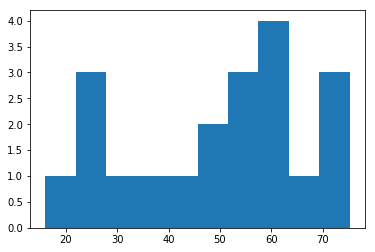

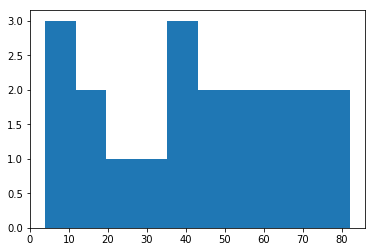

qid 0 [0, 5.304315994901627, 0, 11.29493070936122, 0, 10.357728193901046, 5.800374552030213, 0, 11.111030773770693, 0, 0, 0, 6.835888693433923, 0, 10.302235356938759, 0, 0, 0, 11.37064080896559, 0, 3.894422312986012, 0, 0, 7.983063682985747, 0, 0, 7.756605193684907, 9.409572914229159, 0, 7.148749406713674, 0, 0, 0, 3.12559035884044, 9.13397693167272, 0, 0, 7.105076840792715, 0, 0, 0, 4.172096280427443, 0, 4.527938086103493, 0, 0, 11.129908385822379, 7.653424822677671, 0, 3.77723087073112, 9.322627362349078, 7.508817779134236, 0, 9.634314643668624, 3.1508864017885396, 11.899360449949688, 0, 11.707103397053698, 0, 8.4946137658973, 0, 8.582160699355153, 11.026431189548765, 0, 9.761717707170202, 0, 0, 7.505640217125469, 0, 10.332837859372493, 10.531944323127316, 0, 0, 0, 3.3097489014102095, 3.4575715029446807, 0, 0, 4.957633882295574, 0, 0, 0, 0, 0, 11.64105525404124, 0, 6.4694430589406995, 6.909379471477099, 6.780590797369253, 3.4128513361799095, 8.661989638240108, 0, 0, 0, 4.108278844084

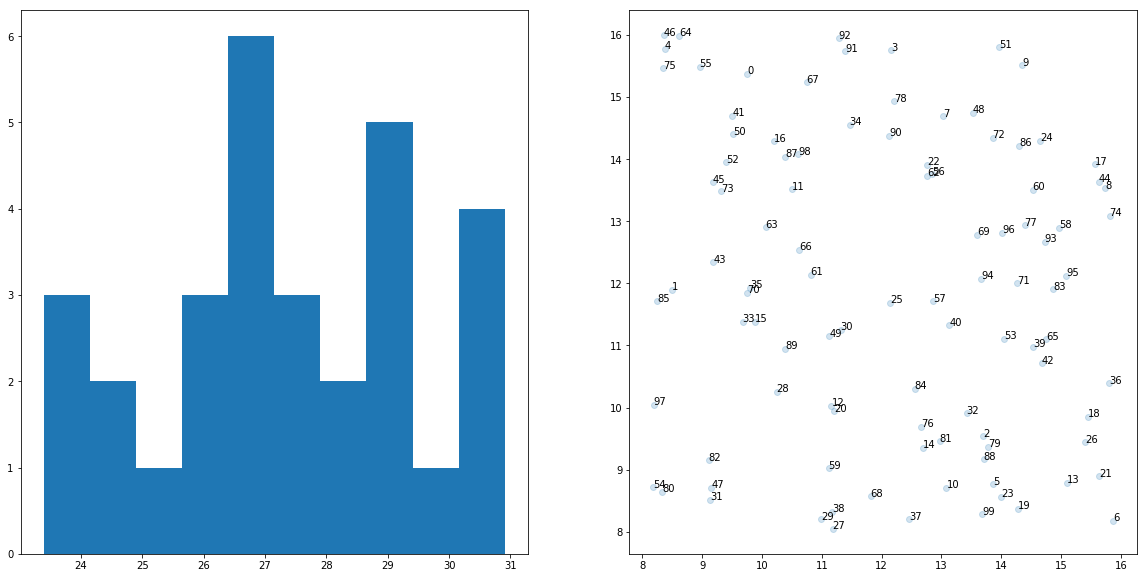

----0

>>Passed 1552/2000
----0

>>Passed 1570/2000
<__main__.BigTable object at 0x7f7855792f98> <__main__.BigTable object at 0x7f78445ab0b8> Tensor("psi_select_1:0", shape=(?, 1), dtype=int32) Tensor("q_select_1:0", shape=(?, 1), dtype=int32)
psi_sel shape (?, 1)
kk (20, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (20, 100)
'rows' shape, (?, 100)
kk (100, 100)
selector shape (?, 1)
flat selector shape (?,)
call kk (100, 100)
'rows' shape, (?, 100)
dif (?, 100)
Pr (?, 1)
[  9.96013355  10.96720505   9.78449059  10.95547771  13.91512108
  11.49815273  14.54670238  10.0698719   11.9912653   10.86492252
  10.03271103  12.15787983  12.54398155  14.30018044  11.44329357
  10.69980431  12.97173214  12.17198086  10.76236153   8.50566101
  12.48022556  15.79001713  14.01410484  10.98135376   9.31600857
   9.12219143   8.8681736   10.79929447  10.62441254  12.13983345
  11.2633543   14.54034042   8.18964958  10.09069538  15.68841839
  13.72481346  15.83411789  13.03040218  10.38

[  8.43315315   8.78371239  11.70208931   9.26898098   9.07657051
  10.47902775   8.08021736  10.08068371  13.72916985   9.41354084
  15.09224701  12.66962051   9.26917267   9.50554276  13.01242065
  14.89883423  10.73170185  13.78822422  12.15432358   8.69510174
  14.71616459   8.05658245  10.09976196   9.33957577   9.37124825
   8.50651073  12.23403263   9.65962315   8.91754532  11.09428406
  13.55508232  12.90642643  11.46352005   9.28321362   9.17254162
  10.92957211  12.36119652  15.0498991   14.64384651  13.54752254
   8.78839779  13.75517368   9.25498676   9.81672859  11.20371532
   8.82465458  15.9696331   14.39390469  14.17596912   8.27079964
  11.02114964  15.37647533  14.84781075  15.41688061  14.50387764
   9.37963963  11.78627777  10.74857044  14.59834671   9.58580112
  12.71391392  11.15302277  13.52346897  13.98655224   8.11144924
   9.91559219  12.94865131  12.14454174   9.36276245  13.7746315
  13.81982517  11.80290985  11.78395462  15.42917824  11.44818211
  15.798367

[(0, 10, 1, 1), (0, 1, 1, 1), (0, 12, 1, 1), (0, 14, 0, 0), (0, 4, 1, 1), (0, 5, 0, 0), (0, 17, 1, 1), (0, 16, 1, 1), (0, 18, 1, 1), (0, 9, 1, 1), (0, 11, 1, 1), (0, 13, 1, 1), (0, 2, 0, 0), (0, 3, 1, 1), (0, 8, 1, 1), (0, 15, 1, 1), (0, 0, 1, 1), (0, 19, 1, 1), (0, 7, 1, 1), (0, 6, 1, 1), (1, 16, 1, 1), (1, 2, 0, 0), (1, 1, 0, 0), (1, 13, 1, 1), (1, 6, 0, 0), (1, 3, 1, 1), (1, 8, 0, 0), (1, 18, 1, 1), (1, 5, 1, 1), (1, 14, 0, 0), (1, 10, 0, 0), (1, 19, 1, 1), (1, 12, 0, 0), (1, 11, 1, 1), (1, 9, 1, 1), (1, 7, 1, 1), (1, 15, 0, 0), (1, 4, 1, 1), (1, 0, 1, 1), (1, 17, 1, 1), (2, 8, 0, 0), (2, 17, 1, 1), (2, 1, 0, 0), (2, 7, 1, 1), (2, 9, 1, 1), (2, 12, 1, 1), (2, 18, 1, 1), (2, 3, 1, 1), (2, 2, 1, 1), (2, 5, 1, 1), (2, 6, 1, 1), (2, 15, 1, 1), (2, 13, 1, 1), (2, 10, 0, 0), (2, 11, 1, 1), (2, 4, 1, 1), (2, 19, 1, 1), (2, 14, 1, 1), (2, 16, 0, 0), (2, 0, 1, 1), (3, 6, 1, 1), (3, 8, 1, 1), (3, 15, 1, 1), (3, 11, 1, 1), (3, 5, 1, 1), (3, 18, 1, 1), (3, 16, 1, 1), (3, 9, 1, 1), (3, 4, 1, 1),

i = 780
4.79171763229 0.775887908936 0.215
av RMSE= 4.79171763229
patience reset to 10
i = 790
4.72553894043 0.775332361221 0.215
av RMSE= 4.72553894043
patience reset to 10
i = 800
4.66074632263 0.774752812386 0.215
av RMSE= 4.66074632263
patience reset to 10
i = 810
4.59729346848 0.774148735046 0.215
av RMSE= 4.59729346848
patience reset to 10
i = 820
4.53513568497 0.773519611835 0.215
av RMSE= 4.53513568497
patience reset to 10
i = 830
4.47423122787 0.772864916801 0.215
av RMSE= 4.47423122787
patience reset to 10
i = 840
4.41454106522 0.772184142113 0.215
av RMSE= 4.41454106522
patience reset to 10
i = 850
4.35602775764 0.771476784706 0.215
av RMSE= 4.35602775764
patience reset to 10
i = 860
4.2986557579 0.770742378235 0.215
av RMSE= 4.2986557579
patience reset to 10
i = 870
4.24239178085 0.769980453491 0.215
av RMSE= 4.24239178085
patience reset to 10
i = 880
4.18720349693 0.769190532207 0.215
av RMSE= 4.18720349693
patience reset to 10
i = 890
4.13305838585 0.768372172832 0.215
av

i = 1740
1.68012674141 0.590755782604 0.2155
av RMSE= 1.68012674141
patience reset to 10
i = 1750
1.66576321602 0.587785949707 0.2155
av RMSE= 1.66576321602
patience reset to 10
i = 1760
1.65159188747 0.584810814381 0.2155
av RMSE= 1.65159188747
patience reset to 10
i = 1770
1.63760971832 0.581830930233 0.2155
av RMSE= 1.63760971832
patience reset to 10
i = 1780
1.62381381893 0.578846867085 0.2155
av RMSE= 1.62381381893
patience reset to 10
i = 1790
1.61020133781 0.57585918045 0.216
av RMSE= 1.61020133781
patience reset to 10
i = 1800
1.59676943588 0.572868391991 0.216
av RMSE= 1.59676943588
patience reset to 10
i = 1810
1.58351531601 0.569875050545 0.216
av RMSE= 1.58351531601
patience reset to 10
i = 1820
1.57043624973 0.566879658699 0.2165
av RMSE= 1.57043624973
patience reset to 10
i = 1830
1.55752956581 0.563882764816 0.2165
av RMSE= 1.55752956581
patience reset to 10
i = 1840
1.54479257393 0.560884868622 0.2165
av RMSE= 1.54479257393
patience reset to 10
i = 1850
1.53222282696 0.

i = 2680
0.887997193813 0.34099768734 0.274
av RMSE= 0.887997193813
patience reset to 10
i = 2690
0.883464429855 0.338988914013 0.275
av RMSE= 0.883464429855
patience reset to 10
i = 2700
0.878982013226 0.336996119022 0.277
av RMSE= 0.878982013226
patience reset to 10
i = 2710
0.874549246311 0.335019259453 0.279
av RMSE= 0.874549246311
patience reset to 10
i = 2720
0.870165529251 0.333058302402 0.281
av RMSE= 0.870165529251
patience reset to 10
i = 2730
0.865830188751 0.331113192558 0.284
av RMSE= 0.865830188751
patience reset to 10
i = 2740
0.861542662144 0.329183920622 0.2875
av RMSE= 0.861542662144
patience reset to 10
i = 2750
0.857302318096 0.327270420313 0.2885
av RMSE= 0.857302318096
patience reset to 10
i = 2760
0.85310849762 0.325372619629 0.2925
av RMSE= 0.85310849762
patience reset to 10
i = 2770
0.848960631371 0.32349049592 0.298
av RMSE= 0.848960631371
patience reset to 10
i = 2780
0.84485816288 0.321623991489 0.303
av RMSE= 0.84485816288
patience reset to 10
i = 2790
0.84

i = 3590
0.622037897587 0.21507153964 0.7065
av RMSE= 0.622037897587
patience reset to 10
i = 3600
0.62025952673 0.214208462954 0.711
av RMSE= 0.62025952673
patience reset to 10
i = 3610
0.618498323441 0.213354115725 0.714
av RMSE= 0.618498323441
patience reset to 10
i = 3620
0.616754150391 0.212508432627 0.719
av RMSE= 0.616754150391
patience reset to 10
i = 3630
0.615026828766 0.211671329975 0.72
av RMSE= 0.615026828766
patience reset to 10
i = 3640
0.613316157341 0.210842726707 0.723
av RMSE= 0.613316157341
patience reset to 10
i = 3650
0.611621969223 0.210022544146 0.727
av RMSE= 0.611621969223
patience reset to 10
i = 3660
0.6099441185 0.209210707068 0.7305
av RMSE= 0.6099441185
patience reset to 10
i = 3670
0.608282401085 0.208407132626 0.7345
av RMSE= 0.608282401085
patience reset to 10
i = 3680
0.606636671066 0.207611746073 0.738
av RMSE= 0.606636671066
patience reset to 10
i = 3690
0.605006750107 0.206824460745 0.7385
av RMSE= 0.605006750107
patience reset to 10
i = 3700
0.603

i = 4510
0.51255678153 0.163432215452 0.822
av RMSE= 0.51255678153
patience reset to 10
i = 4520
0.511813032866 0.163094566703 0.8215
av RMSE= 0.511813032866
patience reset to 10
i = 4530
0.511076339245 0.162760273099 0.821
av RMSE= 0.511076339245
patience reset to 10
i = 4540
0.510346709251 0.162429327607 0.8205
av RMSE= 0.510346709251
patience reset to 10
i = 4550
0.50962395668 0.162101647854 0.8205
av RMSE= 0.50962395668
patience reset to 10
i = 4560
0.508908001423 0.161777191639 0.819
av RMSE= 0.508908001423
patience reset to 10
i = 4570
0.508198907375 0.161455984473 0.82
av RMSE= 0.508198907375
patience reset to 10
i = 4580
0.507496528625 0.161137948155 0.82
av RMSE= 0.507496528625
patience reset to 10
i = 4590
0.506801064491 0.160823167682 0.8205
av RMSE= 0.506801064491
patience reset to 10
i = 4600
0.506112205505 0.160511510015 0.8205
av RMSE= 0.506112205505
patience reset to 10
i = 4610
0.505429982185 0.160202976346 0.8205
av RMSE= 0.505429982185
patience reset to 10
i = 4620
0

i = 5420
0.468543068886 0.143662360787 0.827
av RMSE= 0.468543068886
patience reset to 10
i = 5430
0.468290770769 0.143545840502 0.827
av RMSE= 0.468290770769
patience reset to 10
i = 5440
0.468042899847 0.143431060314 0.827
av RMSE= 0.468042899847
patience reset to 10
i = 5450
0.467799413443 0.143317985237 0.827
av RMSE= 0.467799413443
patience reset to 10
i = 5460
0.467560224295 0.143206583917 0.827
av RMSE= 0.467560224295
patience reset to 10
i = 5470
0.467325355291 0.14309686029 0.827
av RMSE= 0.467325355291
patience reset to 10
i = 5480
0.467094772816 0.142988788962 0.8265
av RMSE= 0.467094772816
patience reset to 10
i = 5490
0.466868371248 0.142882350087 0.8265
av RMSE= 0.466868371248
patience reset to 10
i = 5500
0.466645272732 0.142777364492 0.8265
av RMSE= 0.466645272732
patience reset to 10
i = 5510
0.466426403522 0.142673996687 0.8265
av RMSE= 0.466426403522
patience reset to 10
i = 5520
0.466211791992 0.14257225728 0.8265
av RMSE= 0.466211791992
patience reset to 10
i = 553

NameError: name 'h_of_hs' is not defined

In [25]:
from IPython.display import clear_output
serieses = []
min_errs = []
n_qs = 20
n_students = 100
opt = Adam()# (lr=.75)

# 1 (1836, (4279, 4082, 825, 814), 3, 14, 2, 13)
# 2 (2320, (3840, 3965, 1082, 1113), 10, 20, 9, 16)
# 3 (2398, (4258, 3801, 968, 973), 7, 18, 3, 14)
# 5 (2752, (3624, 3697, 1354, 1325), 8, 16, 3, 12)
# 10 (3640, (3269, 3180, 1769, 1782), 8, 15, 2, 10)
# 25 (4990, (3100, 2505, 2154, 2241), 7, 17, 4, 7)
#100 (3544, (3228, 3330, 1705, 1737), 21, 44, 1, 23)

# mina=8
# maxa=16
# minb=3
# maxb=12
# n_traits=5
# nn_dimensions=[5]

# mina, maxa, minb, max_b = (3, 14, 2, 13)
# n_traits=1
# nn_dimensions=[1]

# mina, maxa, minb, max_b = (10, 20, 9, 16)
# n_traits=2
# nn_dimensions=[2]

mina, maxa, minb, maxb = (8, 16, 3, 12)
n_traits=5
nn_dimensions=[100]

histoires = []
# h_of_hs = {}

qs=None
ss=None
for _ in range(1):
    gc.collect()
    for ix,nnw in enumerate(nn_dimensions):
        if not qs:
            qs, _ = create_qs(n_qs, minb,maxb, n_traits, nnw)
            ss, _ = create_students(n_students, mina,maxa, n_traits, nnw)
            attempts, attempts_by_q, attempts_by_psi, attempts_n_map = generate_attempts(qs,ss)
            v, _, _, _ = generate_attempts(qs,ss)

        q_table = BigTable((n_qs, nnw),min_w=minb, max_w=maxb)
        s_table = BigTable((n_students, nnw), min_w=mina, max_w=maxa)

        q_model = None
        s_model = None
        qs_model = generate_qs_model(q_table, s_table, None, None, opt)
    #     qs_model = None
    #     psi_model = generate_psi_model(s_table, qopt)
        init_weights(qs, ss, attempts_by_psi, attempts_by_q, q_table, s_table, minb, maxb, mina, maxa)

        h = calibrate(qs,ss, qs_model, q_model, s_model, attempts, v, attempts_by_psi, attempts_by_q, s_table, q_table, None, None, n_iter=10000, record_param_fit=True)
    #     histoires.append(h)
        if nnw in h_of_hs:
            h_of_hs[nnw].append(h)
        else:
            h_of_hs[nnw] = [h]

        #qs_model.load_weights("qs_best_weights_summative.hdf5")

[1, 0.7583333333333333, 0.50423949543635049]
[1, 0.75666666666666671, 0.50421409956614172]
[1, 0.7573333333333333, 0.50351038765907286]
[1, 0.75766666666666671, 0.50428296049435939]
[1, 0.75266666682561234, 0.5100254517396291]
[1, 0.75233333349227904, 0.50844761347770695]
[1, 0.75333333349227904, 0.50804948369661962]
[1, 0.75200000015894575, 0.50889105200767515]
[1, 0.74899999984105425, 0.50730733656883242]
[1, 0.75099999984105426, 0.50829686172803246]
[1, 0.74966666650772096, 0.50793165294329323]
[3, 0.77633333317438757, 0.48863806168238322]
[3, 0.76433333333333331, 0.51717957711219786]
[3, 0.75933333349227905, 0.52063232151667282]
[3, 0.76000000000000001, 0.51430004103978477]
[3, 0.75633333349227905, 0.52013460175196324]
[3, 0.74766666650772096, 0.51840278172492982]
[3, 0.76433333333333331, 0.5016885348161062]
[3, 0.76866666666666672, 0.51053786865870154]
[3, 0.75366666666666671, 0.52541076596577962]
[3, 0.75866666650772097, 0.52210928018887837]
[3, 0.75633333317438767, 0.50875444499

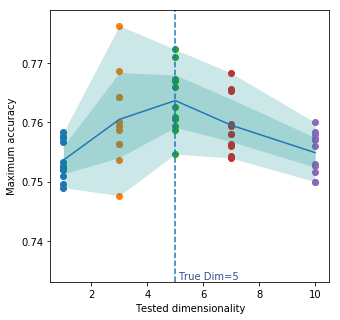

In [106]:
# for w in h_of_hs:
#     for h in h_of_hs[w]:
#     x = range(len(h))
#     loss = [tup[0] for tup in h]
#     acc = [tup[2] for tup in h]
# #     plt.plot(x,loss, label=w)
#     plt.plot(x,acc, label=w)
# plt.gcf().set_size_inches(10, 10)
# plt.legend()
# plt.show()

from collections import defaultdict
import pandas

x=[]
tops=defaultdict(list)
bottoms = defaultdict(list)
N=0
for w in h_of_hs:
    x.append(w)
    for h in h_of_hs[w]:
        max_in_h = max( [tup[2] for tup in h])
        tops[w].append(max_in_h)
        bottoms[w].append( min([tup[0] for tup in h]) )
        N += 1
    
df = pandas.DataFrame(columns=["test_dim","max_acc","min_loss"], index=range(N))
ix=0
for w in h_of_hs:
    for maxacc,minerr in zip(tops[w], bottoms[w]):
        row = [w, maxacc, minerr]
        print(row)
        df.loc[ix,:] = row
        ix+=1
df.to_csv("dimtest.csv")
    
for w in h_of_hs:
    plt.scatter([w for v in tops[w]],[v for v in tops[w]])
plt.plot([x for x in tops],[numpy.mean(vs) for vs in tops.values() ])
plt.gca().fill_between([x for x in tops], [(numpy.mean(vs)+numpy.max(vs))/2 for vs in tops.values() ], [(numpy.mean(vs)+numpy.min(vs))/2 for vs in tops.values() ], color='#008888', alpha=.2, linewidth=0)
plt.gca().fill_between([x for x in tops], [numpy.max(vs) for vs in tops.values() ], [numpy.min(vs) for vs in tops.values() ], color='#008888', alpha=.2, linewidth=0)

plt.gcf().set_size_inches(5, 5)
plt.xlabel("Tested dimensionality")
plt.ylabel("Maximum accuracy")
plt.axvline(x=5, linestyle="--")
plt.text(x=5.1, y=plt.ylim()[0]+.0005, s='True Dim=5', color='#334f8d')
plt.show()


elements in h: 16
(0.91572104566097257, 0.31946941799759865, 0.50490500000000005)
(0.74795270622730259, 0.26656289949178696, 0.55831500000000001)
(0.70781433809757233, 0.25214002320945261, 0.57898000000000005)
(0.69419102789163589, 0.24716706697940827, 0.58570999999999995)
(0.68923943117856978, 0.24506311622858049, 0.59079749999999998)
(0.68936642273187643, 0.24473972714185716, 0.59324750000000004)
(0.69110158857107162, 0.24499028292238711, 0.59500750000000002)
(0.69294615130662918, 0.24527216579735278, 0.59675999999999996)
(0.69496327038288119, 0.245644258351326, 0.59762999999999999)
(0.69681172864198682, 0.24593349490225316, 0.59855499999999995)
(0.69888650999307633, 0.24636338090300561, 0.59948749999999995)
(0.70049507125139232, 0.24661929389417173, 0.60045999999999999)
(0.70214721165895466, 0.24688927276551723, 0.60148250000000003)
(0.70388557514905925, 0.24720468823790551, 0.60189749999999997)
(0.7056189635252953, 0.24751434554576873, 0.60218000000000005)
(0.70692129829645156, 0.2

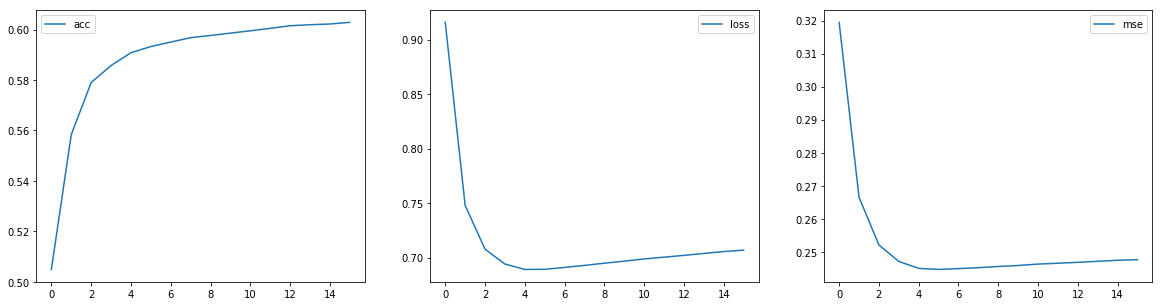

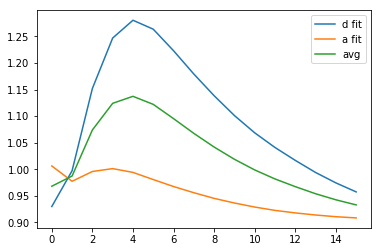

In [41]:
clear_output()
print("elements in h:", len(h))
for tup in h:
    print(tup)

loss, mse, acc = zip(*h)


fig = plt.gcf()
#     plt.xlabel("#iterations")
#     plt.ylabel("fit error (RMSE)")
#     plt.suptitle("Neural-MLTM Parameter Fitting")
#     plt.title("(skills=5, items=10, students=100)")
fig, axes = plt.subplots(nrows=1, ncols=3)
axes[0].plot(acc, label="acc")
axes[1].plot(loss, label="loss")
axes[2].plot(mse, label="mse")

fig.set_size_inches(20, 5)
for i in [0,1,2]:
    axes[i].legend()
plt.show()

av_fit_rmses = []
for b,th in zip(b_fit_rmses, th_fit_rmses):
    av = (b+th)/2.0
    av_fit_rmses.append(av)
    
plt.plot(b_fit_rmses, label="d fit")
plt.plot(th_fit_rmses, label="a fit")
plt.plot(av_fit_rmses, label="avg")
plt.legend()
plt.show()


In [42]:
real_wgtz = array([ q.betas for q in qs ])
pred_wgtz = q_table.get_weights()[0]
chosen, min_total_err, mean_ll, cos_dis = calc_arr_arr_err(real_wgtz, pred_wgtz, max_iter=10)

print("real", real_wgtz)
# print(pred_wgts)
print("out", chosen)
print("best cos distance:", cos_dis)
print("elementwise mae:", min_total_err)
print("mean lead/lag", mean_ll)

real [[ 10.94075004  22.75399221   3.02906814 ...,   6.72877459  20.43593973
   22.75860242]
 [ 18.44587     20.37251586  10.53584258 ...,   4.1173489   13.44871124
    2.26915354]
 [  1.26812714   9.4565488    8.01395252 ...,   7.81788147  11.35180179
    2.91717035]
 ..., 
 [ 17.22519531  21.89358942   7.5251736  ...,  16.71762217  10.37545902
    1.25429202]
 [  1.69554747  12.04235123   2.34800522 ...,   8.62958737   8.70572464
   16.25472114]
 [ 22.20753878  12.25477271   2.63920166 ...,   1.26050169   9.7134637
    1.40080527]]
out [[ 14.57091904   5.11206484  21.26072311 ...,  19.24503326   5.26015949
   21.99741554]
 [  7.53768253  20.50618744  17.39183807 ...,  19.01119804   7.80742502
    7.81177998]
 [ 18.49344635   1.96794021  21.32787895 ...,   7.58776999  11.02748299
   10.37238121]
 ..., 
 [ 19.39649391  21.18089485  18.89954758 ...,  10.91354275  20.27309227
    2.91121435]
 [ 10.47409534  10.81981468   1.44396937 ...,  11.83677197   7.60482073
   20.65550041]
 [ 20.725

In [43]:
x = []

for _ in range(1):
    xa, _, _, _ = generate_attempts(qs,ss)
    x.extend(xa)

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(ss[psi_id].thetas, qs[q_id].betas)
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

----0

>>Passed 200763/400000
model acc: 0.652635
131363 69546
69400 129691
perplexity is 1.6787769647276936
140618 : 131363 129691 69546 69400


In [44]:
sws = s_table.get_weights()[0]

tp,fp,tn,fn=0,0,0,0
base = 2
summa=0
N = len(x)
for tup in x:
    (psi_id, q_id, passed, passed) = tup
    p = calculate_pass_probability(sws[psi_id], pred_wgtz[q_id])
    summa += log((p if passed else (1-p)), base)

    pp = uniform(0,1)
    if pp <= p:
        if passed:
            tp+=1
        else:
            fp+=1
    else:
        if passed:
            fn+=1
        else:
            tn+=1

acc = (tp+tn)/len(x)
print("model acc:",acc)
print(tp,fp)
print(fn,tn)

ppx = pow( base, (-summa/N))
print("perplexity is {}".format(ppx))
print((fn + fp + abs(tp-tn)),":", tp,tn,fp,fn)

model acc: 0.5428025
108983 91099
91780 108138
perplexity is 1.993226564630819
183724 : 108983 108138 91099 91780


(200, 100) (200, 100)


/auto/homes/rjm49/.venvs/isaac36/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


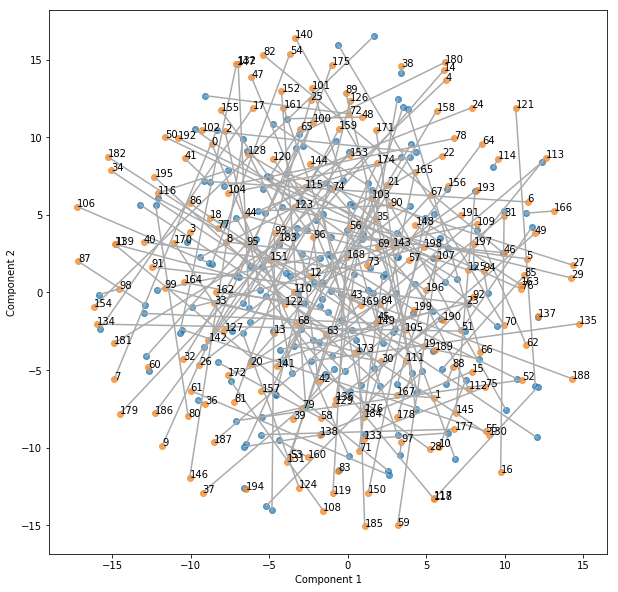

In [45]:
## fig = plt.gcf()
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# pca = PCA(n_components=2)
pca = TSNE(n_components=2)
# pca2 = TSNE(n_components=2)

itemz = array([ q.betas for q in qs ])
# ixes = itemz < baseline
# itemz[ixes] = (baseline-1)
# itemz = itemz - (baseline-1)

itemz_pred = chosen
n = len(chosen)

print(itemz.shape, itemz_pred.shape)


# itemz_pred = pca.transform(itemz_pred)

itemz_2 = numpy.concatenate([itemz, itemz_pred], axis=0)
itemz_2 = pca.fit_transform(itemz_2)

# itemz_2 = MinMaxScaler().fit_transform(itemz_2)

# ixes = itemz_pred < baseline
# itemz_pred[ixes] = (baseline-1)
# itemz_pred = itemz_pred - (baseline-1)
# itemz_pred = MinMaxScaler().fit_transform(itemz_pred)
# print(itemz_2)

# fig,axs = plt.subplots(1,2)
fig = plt.gcf()
fig.set_size_inches(10, 10)

fig.gca().scatter(itemz_2[0:n,0], itemz_2[0:n,1], alpha=0.7)
fig.gca().scatter(itemz_2[n:,0], itemz_2[n:,1], alpha=0.7)
j=0
for j in range(n):
    x,xh,y,yh = itemz_2[j,0], itemz_2[j+n,0], itemz_2[j,1], itemz_2[j+n,1]
    fig.gca().plot([x,xh],[y,yh],color="#aaaaaa")
    fig.gca().annotate(j, (itemz_2[j+n,0], itemz_2[j+n,1]))

# fig.gca().scatter(itemz_pred[:,0], itemz_pred[:,1], alpha=0.5)

# for i, txt in enumerate(itemz_2):
#     fig.gca().annotate(i, (itemz_2[i,0], itemz_2[i,1]))

# fig.gca().axvline(x=baseline, linestyle="--")
# fig.gca().axhline(y=baseline, linestyle="--")

plt.xlabel("Component 1")
plt.ylabel("Component 2")
fig.show()